Big Data Analysis - Final Project
2018312856 Ko Sungwon

Due to GPU memory limit in py local PC environment, I splited tast  3, 4 to this file.
-----------
Task 3. Make Ensemble of Xception and EfficientNet

In [1]:
# 필요한 라이브러리 호출 / 디바이스 확인, 할당
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms # 이미지 변환 기능을 제공하는 라이브러리
from torch.autograd import Variable
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models # 다양한 파이토치 네트워크를 사용할 수 있게 해주는 패키지
from torchsummary import summary
from sklearn.metrics import classification_report

import os
import cv2
import time
import glob
from PIL import Image
from tqdm import tqdm_notebook as tqdm
import random
import copy
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

USE_CUDA = torch.cuda.is_available()
device = torch.device('cuda:0' if USE_CUDA else 'cpu')

print('CUDA 사용 가능 여부: ', USE_CUDA)
print('현재 사용 device: ', device)
print('CUDA Index', torch.cuda.current_device())
print('GPU 이름: ', torch.cuda.get_device_name())
print('GPU 개수: ', torch.cuda.device_count())

c:\Users\82104\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


CUDA 사용 가능 여부:  True
현재 사용 device:  cuda:0
CUDA Index 0
GPU 이름:  GeForce GTX 1650 Ti
GPU 개수:  1


In [2]:
# Custom Dataset for final project! 
class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.Resize(224),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'test': transforms.Compose([
                transforms.Resize(224),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
        }
    def __call__(self, img, phase):
        return self.data_transform[phase](img)

class CustomDataset(Dataset):
    "Load test data, image from test image folder"
    def __init__(self, test_df, root_dir, transform = None, phase='train'):
        self.test_df = test_df
        self.root_dir = root_dir
        self.phase = phase
        self.transform = transform

    def __len__(self):
        return self.test_df.shape[0]
    
    def __getitem__(self, idx):
        video = self.test_df.iloc[idx, 0]
        face = self.test_df.iloc[idx, 1]
        label = self.test_df.iloc[idx, 2]
        img_path = self.root_dir + video + '/' + face

        img = Image.open(img_path)
        img_transformed = self.transform(img, self.phase)

        reverse_label = 1-label # I used opposite label for previous HW.

        return img_transformed, reverse_label

In [3]:
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

In [4]:
org_train_df = pd.read_csv("./data/2018312856/your_prediction.csv", sep=',')
print(org_train_df.shape)
print('size of data: ', org_train_df.shape[0])
print(org_train_df.columns)

index = 10
test_dataset = CustomDataset(org_train_df, root_dir = './data/2018312856/', transform=ImageTransform(size, mean, std), phase='test')
print('test dataset check')
print(test_dataset.__getitem__(index)[0].size())
print(test_dataset.__getitem__(index)[1])

(80, 4)
size of data:  80
Index(['video', 'face', 'label', 'predict'], dtype='object')
test dataset check
torch.Size([3, 224, 224])
0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

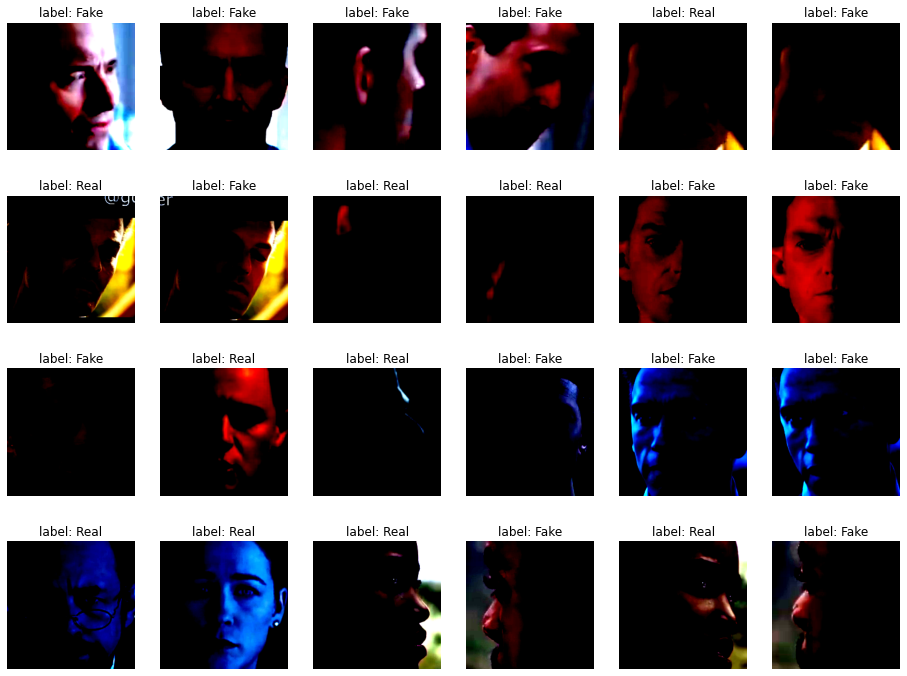

In [5]:
# 테스트 데이터 로더 정의 및 이미지, 레이블 확인
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

samples, labels = iter(test_dataloader).next()
fig = plt.figure(figsize=(16,24))
for i in range(24):
    a = fig.add_subplot(4, 6, i+1)
    if labels[i] == 1:
        label = 'Real'
    else:
        label = 'Fake'
    a.set_title('label: {}'.format(label))
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1, 2, 0))) # 원래 samples[i] = (3, 224, 224)꼴임. 그러나 imshow로 출력하려면..(224, 224, 3 꼴로 바꿔줘야 함)


plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)
plt.show()

In [6]:
# 테스트 데이터 평가 함수 생성
def eval_model(model_1, model_2, model_1_path, model_2_path, dataloaders, device):
    since = time.time()
    acc_history = []
    best_acc = 0.0

    full_labels = []
    full_preds = []
    

    model_1.load_state_dict(torch.load(model_1_path))
    model_1.eval()
    model_1.to(device)

    model_2.load_state_dict(torch.load(model_2_path))
    model_2.eval()
    model_2.to(device)

    print(type(model_1))
    print(type(model_2))

    running_corrects = 0

    for inputs, labels in dataloaders:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad(): # auto-grad 사용하지 않음. 그냥 순전파만 시킨다!
            outputs_1 = model_1(inputs)
            outputs_2 = model_2(inputs)
            outputs = outputs_1*0.5 + outputs_2*0.5 # 두 모델의 평균을 사용

        _, preds = torch.max(outputs.data, 1)
        preds[preds >= 0.5] = 1
        preds[preds < 0.5] = 0
        running_corrects += preds.eq(labels).int().sum()

        labels = labels.detach().cpu().numpy()        
        preds = preds.detach().cpu().numpy()
        for i in range(len(labels)):
            full_labels.append(labels[i])
            full_preds.append(preds[i])

    epoch_acc = running_corrects.double() / len(dataloaders.dataset)
    print('Acc: {:.4f}'.format(epoch_acc))

    if epoch_acc > best_acc:
        best_acc = epoch_acc
    acc_history.append(epoch_acc.item())
    print()

    time_elapsed = time.time() - since
    print('Test complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60))
    print('Best Acc: {:4f}'.format(best_acc))

    print(classification_report(full_labels,full_preds))
    del model_1
    del model_2

    return acc_history

In [7]:
# test with Xception models
import timm

# Create Xception model
xception = timm.create_model('xception', pretrained=True)
xception.fc = nn.Linear(2048, 2)

LQ_xception_path = './models/LQ_f2f_Xception_best.pth'
HQ_xception_path = './models/HQ_nt_Xception_best.pth'


efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)
new_classifier = nn.Sequential(
    nn.AdaptiveAvgPool2d(output_size=1),
    nn.Flatten(),
    nn.Dropout(p=0.2, inplace=False),
    nn.Linear(in_features=1280, out_features=2, bias=True)
)

efficientnet.classifier = new_classifier

LQ_EfficientNet_path = './models/LQ_f2f_EfficientNet_best.pth'
HQ_EfficientNet_path = './models/HQ_nt_EfficientNet_best.pth'

Ensemble_model_test_acc_hist = eval_model(xception, efficientnet, HQ_xception_path, LQ_EfficientNet_path , test_dataloader, device)

c:\Users\82104\anaconda3\lib\site-packages\timm\models\_factory.py:114: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
Using cache found in C:\Users\82104/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub
C:\Users\82104/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub\PyTorch\Classification\ConvNets\image_classification\models\common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
C:\Users\82104/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub\PyTorch\Classification\ConvNets\image_classification\models\efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


<class 'timm.models.xception.Xception'>
<class 'PyTorch.Classification.ConvNets.image_classification.models.efficientnet.EfficientNet'>
Acc: 0.4000

Test complete in 0m 5s
Best Acc: 0.400000
              precision    recall  f1-score   support

           0       0.41      0.20      0.27        44
           1       0.40      0.64      0.49        36

    accuracy                           0.40        80
   macro avg       0.40      0.42      0.38        80
weighted avg       0.40      0.40      0.37        80



In [8]:
# Ensemble model 2.
# This time, I will be using all 4 models.

# 테스트 데이터 평가 함수 생성
def eval_ensemble_model(model_1, model_2, model_3, model_4, model_1_path, model_2_path, model_3_path, model_4_path, dataloaders, device):
    since = time.time()
    acc_history = []
    best_acc = 0.0

    full_labels = []
    full_preds = []
    

    model_1.load_state_dict(torch.load(model_1_path))
    model_1.eval()
    model_1.to(device)

    model_2.load_state_dict(torch.load(model_2_path))
    model_2.eval()
    model_2.to(device)

    model_3.load_state_dict(torch.load(model_3_path))
    model_3.eval()
    model_3.to(device)

    model_4.load_state_dict(torch.load(model_4_path))
    model_4.eval()
    model_4.to(device)

    print(type(model_1))
    print(type(model_2))
    print(type(model_3))
    print(type(model_4))

    running_corrects = 0

    for inputs, labels in dataloaders:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad(): # auto-grad 사용하지 않음. 그냥 순전파만 시킨다!
            outputs_1 = model_1(inputs)
            outputs_2 = model_2(inputs)
            outputs_3 = model_3(inputs)
            outputs_4 = model_4(inputs)
            outputs = outputs_1*0.25 + outputs_2*0.25 + outputs_3*0.25 + outputs_4*0.25 # 네 모델의 평균을 사용

        _, preds = torch.max(outputs.data, 1)
        preds[preds >= 0.5] = 1
        preds[preds < 0.5] = 0
        running_corrects += preds.eq(labels).int().sum()

        labels = labels.detach().cpu().numpy()        
        preds = preds.detach().cpu().numpy()
        for i in range(len(labels)):
            full_labels.append(labels[i])
            full_preds.append(preds[i])

    epoch_acc = running_corrects.double() / len(dataloaders.dataset)
    print('Acc: {:.4f}'.format(epoch_acc))

    if epoch_acc > best_acc:
        best_acc = epoch_acc
    acc_history.append(epoch_acc.item())
    print()

    time_elapsed = time.time() - since
    print('Test complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60))
    print('Best Acc: {:4f}'.format(best_acc))

    print(classification_report(full_labels,full_preds))
    del model_1
    del model_2
    del model_3
    del model_4
    return acc_history

In [9]:
Ensemble_model_test_acc_hist = eval_ensemble_model(xception, xception, efficientnet, efficientnet,
                                          LQ_xception_path, HQ_xception_path, LQ_EfficientNet_path, HQ_EfficientNet_path,
                                          test_dataloader, device)

<class 'timm.models.xception.Xception'>
<class 'timm.models.xception.Xception'>
<class 'PyTorch.Classification.ConvNets.image_classification.models.efficientnet.EfficientNet'>
<class 'PyTorch.Classification.ConvNets.image_classification.models.efficientnet.EfficientNet'>
Acc: 0.3625

Test complete in 0m 2s
Best Acc: 0.362500
              precision    recall  f1-score   support

           0       0.32      0.14      0.19        44
           1       0.38      0.64      0.47        36

    accuracy                           0.36        80
   macro avg       0.35      0.39      0.33        80
weighted avg       0.34      0.36      0.32        80



Task 4. My Own method

In [10]:
def increase_brightness(image, brightness_factor):
    """
    Increase the brightness of an image.

    Args:
        image (PIL.Image.Image): Input image.
        brightness_factor (float): Brightness adjustment factor.
            - 0 will make the image completely black.
            - 1 will keep the original image unchanged.
            - Greater than 1 will make the image brighter.

    Returns:
        PIL.Image.Image: Brightened image.
    """
    # Convert the image to the RGB mode if it's not already in RGB
    image = image.convert("RGB")

    # Create a new image with the same size and mode
    brightened_image = Image.new(image.mode, image.size)

    # Apply brightness adjustment to each pixel
    pixel_map = brightened_image.load()
    width, height = image.size
    for x in range(width):
        for y in range(height):
            r, g, b = image.getpixel((x, y))
            r = int(r * brightness_factor)
            g = int(g * brightness_factor)
            b = int(b * brightness_factor)
            pixel_map[x, y] = (r, g, b)

    return brightened_image

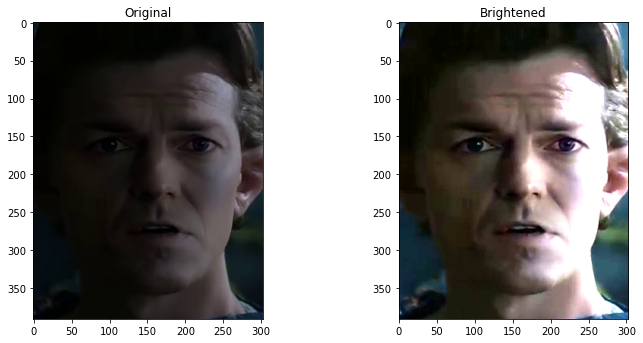

In [29]:
# Open the input image
input_image = Image.open("./data/2018312856/video_3/face_3.png")

# Increase brightness by a factor of 1.5
brightened_image = increase_brightness(input_image, 3)

# Save the brightened image
# brightened_image.save("brightened_image.jpg")
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.title('Original')
plt.imshow(input_image)
plt.subplot(2, 2, 2)
plt.title('Brightened')
plt.imshow(brightened_image)
plt.show()

In [46]:
class BrightCustomDataset(Dataset):
    "Load test data, image from test image folder"
    def __init__(self, test_df, root_dir, transform = None, phase='train'):
        self.test_df = test_df
        self.root_dir = root_dir
        self.phase = phase
        self.transform = transform

    def __len__(self):
        return self.test_df.shape[0]
    
    def __getitem__(self, idx):
        video = self.test_df.iloc[idx, 0]
        face = self.test_df.iloc[idx, 1]
        label = self.test_df.iloc[idx, 2]
        img_path = self.root_dir + video + '/' + face

        img = Image.open(img_path)
        brightened_image = increase_brightness(img, 1.65)
        img_transformed = self.transform(brightened_image, self.phase)
    
        reverse_label = 1-label # I used opposite label for previous HW.

        return img_transformed, reverse_label

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

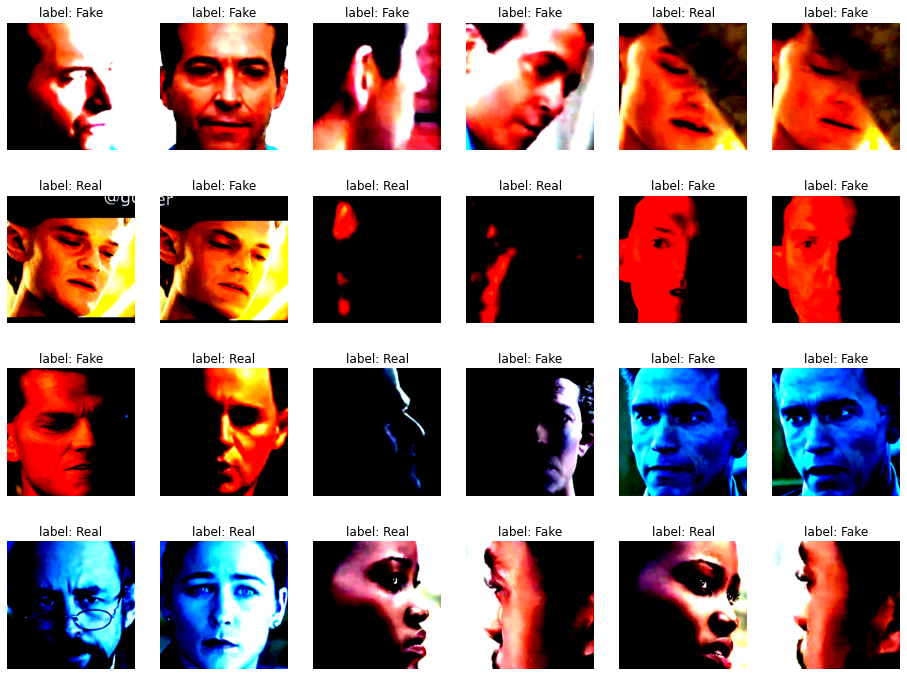

In [47]:
test_dataset = BrightCustomDataset(org_train_df, root_dir = './data/2018312856/', transform=ImageTransform(size, mean, std), phase='test')
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

samples, labels = iter(test_dataloader).next()
fig = plt.figure(figsize=(16,24))
for i in range(24):
    a = fig.add_subplot(4, 6, i+1)
    if labels[i] == 1:
        label = 'Real'
    else:
        label = 'Fake'
    a.set_title('label: {}'.format(label))
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1, 2, 0))) # 원래 samples[i] = (3, 224, 224)꼴임. 그러나 imshow로 출력하려면..(224, 224, 3 꼴로 바꿔줘야 함)


plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)
plt.show()

In [48]:
def eval_model(model, model_path, dataloaders, device):
    since = time.time()
    acc_history = []
    best_acc = 0.0

    full_labels = []
    full_preds = []
    

    model.load_state_dict(torch.load(model_path))
    model.eval()
    model.to(device)
    running_corrects = 0

    for inputs, labels in dataloaders:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad(): # auto-grad 사용하지 않음. 그냥 순전파만 시킨다!
            outputs = model(inputs)

        _, preds = torch.max(outputs.data, 1)
        preds[preds >= 0.5] = 1
        preds[preds < 0.5] = 0
        running_corrects += preds.eq(labels).int().sum()

        labels = labels.detach().cpu().numpy()        
        preds = preds.detach().cpu().numpy()
        for i in range(len(labels)):
            full_labels.append(labels[i])
            full_preds.append(preds[i])

    epoch_acc = running_corrects.double() / len(dataloaders.dataset)
    print('Acc: {:.4f}'.format(epoch_acc))

    if epoch_acc > best_acc:
        best_acc = epoch_acc
    acc_history.append(epoch_acc.item())
    print()

    time_elapsed = time.time() - since
    print('Test complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60))
    print('Best Acc: {:4f}'.format(best_acc))

    print(classification_report(full_labels,full_preds))

    del model # free GPU memory
    return acc_history

In [49]:
# test with Xception models
import timm

# Create Xception model
xception = timm.create_model('xception', pretrained=True)
xception.fc = nn.Linear(2048, 2)

LQ_xception_path = './models/LQ_f2f_Xception_best.pth'
HQ_xception_path = './models/HQ_nt_Xception_best.pth'

print("LQ - Xception model result")
LQ_Xception_test_acc_hist = eval_model(xception, LQ_xception_path ,test_dataloader, device)
print("\nHQ - Xception model result")
HQ_Xception_test_acc_hist = eval_model(xception, HQ_xception_path ,test_dataloader, device)

c:\Users\82104\anaconda3\lib\site-packages\timm\models\_factory.py:114: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


LQ - Xception model result
Acc: 0.4625

Test complete in 0m 10s
Best Acc: 0.462500
              precision    recall  f1-score   support

           0       0.51      0.52      0.52        44
           1       0.40      0.39      0.39        36

    accuracy                           0.46        80
   macro avg       0.46      0.46      0.46        80
weighted avg       0.46      0.46      0.46        80


HQ - Xception model result
Acc: 0.4625

Test complete in 0m 12s
Best Acc: 0.462500
              precision    recall  f1-score   support

           0       0.51      0.50      0.51        44
           1       0.41      0.42      0.41        36

    accuracy                           0.46        80
   macro avg       0.46      0.46      0.46        80
weighted avg       0.46      0.46      0.46        80



In [50]:
# test with EfficientNet models

efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)
new_classifier = nn.Sequential(
    nn.AdaptiveAvgPool2d(output_size=1),
    nn.Flatten(),
    nn.Dropout(p=0.2, inplace=False),
    nn.Linear(in_features=1280, out_features=2, bias=True)
)

efficientnet.classifier = new_classifier

LQ_EfficientNet_path = './models/LQ_f2f_EfficientNet_best.pth'
HQ_EfficientNet_path = './models/HQ_nt_EfficientNet_best.pth'

print("LQ - EfficientNet model result")
LQ_efficientnet_test_acc_hist = eval_model(efficientnet, LQ_EfficientNet_path ,test_dataloader, device)
print("\nHQ - EfficientNet model result")
HQ_efficientnet_test_acc_hist = eval_model(efficientnet, HQ_EfficientNet_path ,test_dataloader, device)

Using cache found in C:\Users\82104/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub


LQ - EfficientNet model result
Acc: 0.4375

Test complete in 0m 10s
Best Acc: 0.437500
              precision    recall  f1-score   support

           0       0.48      0.34      0.40        44
           1       0.41      0.56      0.47        36

    accuracy                           0.44        80
   macro avg       0.45      0.45      0.44        80
weighted avg       0.45      0.44      0.43        80


HQ - EfficientNet model result
Acc: 0.4250

Test complete in 0m 12s
Best Acc: 0.425000
              precision    recall  f1-score   support

           0       0.47      0.39      0.42        44
           1       0.39      0.47      0.42        36

    accuracy                           0.42        80
   macro avg       0.43      0.43      0.42        80
weighted avg       0.43      0.42      0.42        80



In [61]:
# 테스트 데이터 평가 함수 생성
def eval_ensemble_model(model_1, model_2, model_3, model_1_path, model_2_path, model_3_path, dataloaders, device):
    since = time.time()
    acc_history = []
    best_acc = 0.0

    full_labels = []
    full_preds = []
    

    model_1.load_state_dict(torch.load(model_1_path))
    model_1.eval()
    model_1.to(device)

    model_2.load_state_dict(torch.load(model_2_path))
    model_2.eval()
    model_2.to(device)

    model_3.load_state_dict(torch.load(model_3_path))
    model_3.eval()
    model_3.to(device)

    print(type(model_1))
    print(type(model_2))
    print(type(model_3))


    running_corrects = 0

    for inputs, labels in dataloaders:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad(): # auto-grad 사용하지 않음. 그냥 순전파만 시킨다!
            outputs_1 = model_1(inputs)
            outputs_2 = model_2(inputs)
            outputs_3 = model_3(inputs)
            outputs = outputs_1*0.33 + outputs_2*0.33 + outputs_3*0.33 # 세 모델의 평균을 사용

        _, preds = torch.max(outputs.data, 1)
        preds[preds >= 0.5] = 1
        preds[preds < 0.5] = 0
        running_corrects += preds.eq(labels).int().sum()

        labels = labels.detach().cpu().numpy()        
        preds = preds.detach().cpu().numpy()
        for i in range(len(labels)):
            full_labels.append(labels[i])
            full_preds.append(preds[i])

    epoch_acc = running_corrects.double() / len(dataloaders.dataset)
    print('Acc: {:.4f}'.format(epoch_acc))

    if epoch_acc > best_acc:
        best_acc = epoch_acc
    acc_history.append(epoch_acc.item())
    print()

    time_elapsed = time.time() - since
    print('Test complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60))
    print('Best Acc: {:4f}'.format(best_acc))

    print(classification_report(full_labels,full_preds))
    del model_1
    del model_2
    del model_3
    return acc_history

In [62]:
# Load ResNet18
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Linear(512, 2)
resnet18.to(device)
summary(resnet18, input_size = (3, 224, 224))

LQ_ResNet_path = './models/LQ_f2f_ResNet_best.pth'

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [63]:
Ensemble_model_test_acc_hist = eval_ensemble_model(xception, efficientnet, resnet18,
                                          LQ_xception_path, LQ_EfficientNet_path, LQ_ResNet_path,
                                          test_dataloader, device)

<class 'timm.models.xception.Xception'>
<class 'PyTorch.Classification.ConvNets.image_classification.models.efficientnet.EfficientNet'>
<class 'torchvision.models.resnet.ResNet'>
Acc: 0.3500

Test complete in 0m 11s
Best Acc: 0.350000
              precision    recall  f1-score   support

           0       0.40      0.39      0.40        44
           1       0.29      0.31      0.30        36

    accuracy                           0.35        80
   macro avg       0.35      0.35      0.35        80
weighted avg       0.35      0.35      0.35        80

